# Exploratory Analysis of Node Data
## Summary of Data


In [30]:
import pandas as pd 

df = pd.read_csv("../data/5_nodes_1_week_fault_processed.csv")
# print(df.columns)
df = df[df['node_id_4120'] == 1]
df = df.drop(columns=['Unnamed: 0', 'is_fault',  'rtt_2s_mean', 'rtt_3s_mean', 'rtt_4s_mean', 'rtt_5s_mean',
       'rtt_10s_mean', 'rtt_30s_mean', 'rtt_1min_mean', 'rtt_5min_mean', 'event_count_rssi', 'event_count_rsrq',
       'event_count_rsrp',  'node_id_4120', 'node_id_4125', 'node_id_4126', 'node_id_4144',
       'node_id_4147', 'population_HIGH', 'population_LOW',
       'population_MEDIUM', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday',  'ts_0', 'ts_1', 'ts_10',
       'ts_11', 'ts_12', 'ts_13', 'ts_14', 'ts_15', 'ts_16', 'ts_17', 'ts_18',
       'ts_19', 'ts_2', 'ts_20', 'ts_21', 'ts_22', 'ts_23', 'ts_3', 'ts_4',
       'ts_5', 'ts_6', 'ts_7', 'ts_8', 'ts_9'])
df['rtt'] = df['rtt_previous']
df['rtt'] = df['rtt'].apply(lambda x: x * 1000)
df = df.drop(columns=['rtt_previous'])
# print(df.columns)
summary_table = df.describe().round(2)
# print(summary_table)
print(summary_table.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & rssi & rsrq & rsrp & rtt \\
\midrule
count & 599109.000000 & 599109.000000 & 599109.000000 & 599108.000000 \\
mean & -63.970000 & -16.690000 & -99.080000 & 45157.100000 \\
std & 4.200000 & 2.310000 & 3.610000 & 208822.140000 \\
min & -78.000000 & -20.000000 & -110.000000 & 9522.000000 \\
25% & -66.000000 & -18.000000 & -101.000000 & 27417.000000 \\
50% & -63.000000 & -17.000000 & -99.000000 & 34231.000000 \\
75% & -61.000000 & -16.000000 & -96.000000 & 42400.000000 \\
max & -54.000000 & -9.000000 & -82.000000 & 36775700.000000 \\
\bottomrule
\end{tabular}



Index(['Unnamed: 0', 'ts', 'node_id', 'network_id', 'service_id', 'scnt',
       'rcnt', 'rtt', 'bin_ts', 'event_ts', 'event_rssi', 'event_count_rssi',
       'bin_rssi', 'event_rsrq', 'event_count_rsrq', 'bin_rsrq', 'event_rsrp',
       'event_count_rsrp', 'bin_rsrp', 'is_fault', 'population'],
      dtype='object')
Lower Bound: 2.6020000000000145, Upper Bound: 58.65799999999998


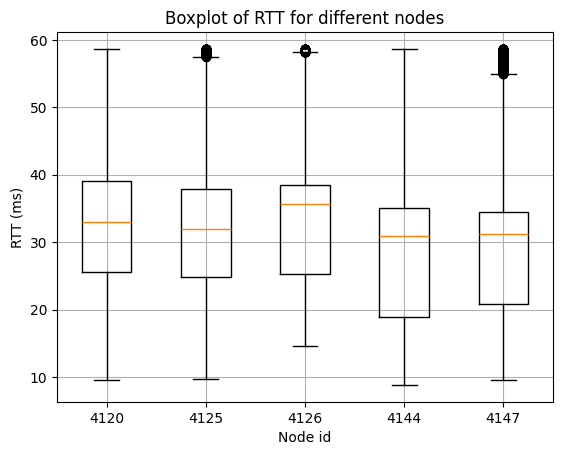

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import sys, os
current_dir = os.getcwd()
plot_dir = os.path.dirname(current_dir) + "/plots"
sys.path.append(plot_dir)
import plot_utils as pu

df = pd.read_csv("../data/5_nodes_1_week_fault.csv")
print(df.columns)

df['rtt'] = df['rtt'].apply(lambda x: x * 1000)
df = pu.remove_outliers_IQR(df, 'rtt')
grouped_data = df.groupby('node_id')['rtt'].apply(list).reset_index()


# Creating boxplot
plt.boxplot(grouped_data['rtt'])
plt.xlabel('Node id')
plt.ylabel('RTT (ms)')
plt.title('Boxplot of RTT for different nodes')
plt.xticks(range(1, len(grouped_data) + 1), grouped_data['node_id'])
plt.grid(True)
plt.savefig('5_node_rtt_boxplt.png')
plt.show()

## K-Means Clustering of the data

### Looking at one specific node

The number of distinct clusters can greatly vary due to the differences in fault causes. It would therefore be interesting to view what number of clusters is the most distinct and to view the separation of two clusters. What are the proportions of faults and stable state in the two clusters?

In [52]:
import pandas as pd 
from sklearn.cluster import KMeans

num_clusters = 2

df = pd.read_csv("../data/5_nodes_1_week_fault_processed.csv")
df = df.iloc[10000:]
# Currently only looking at Node with Id 4126
df = df[df['node_id_4126'] == 1]
df = df.dropna()
X = df.drop(columns=['Unnamed: 0', 'is_fault'])
y = df['is_fault']
kmeans = KMeans(n_clusters=num_clusters, random_state=43).fit(X) 
entry_clusters = kmeans.labels_ # same as kmeans.predict(X) in this case
# entry_clusters = kmeans.predict(X)
clustering_score = 0
for index, cluster in enumerate(entry_clusters):
    clustering_score += 1 if bool(y.iloc[index]) == bool(cluster) else 0

print("Percentage of correctly clustered fault entries: ")
print(str(max(clustering_score/len(y), 1 - clustering_score/len(y)) * 100) + "%")

Percentage of correctly clustered fault entries: 
98.30740260644417%


In [53]:
cluster_count = {}
for cluster in entry_clusters:
    if cluster_count.get(cluster) is None:
        cluster_count[cluster] = 1
    else:
        cluster_count[cluster] += 1
    
print("Cluster distribution: ")
print(cluster_count)

Cluster distribution: 
{0: 603254, 1: 20}


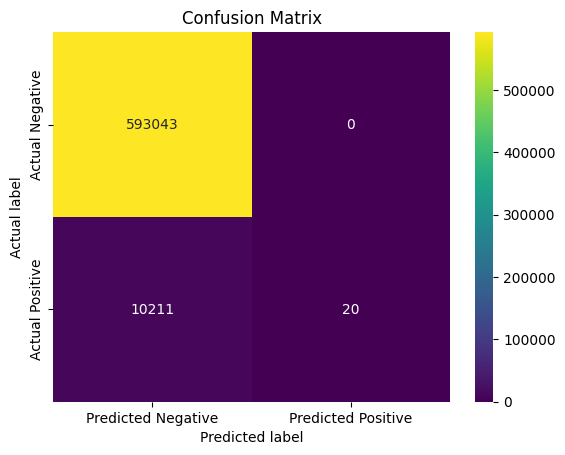

593043


<Figure size 640x480 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check how many of the faults are correct
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
for index, cluster in enumerate(entry_clusters):
    if y.iloc[index] == 1:
        if bool(y.iloc[index]) == bool(cluster):
            true_positives += 1
        else:
            false_negatives += 1
    else:
        if bool(y.iloc[index]) == bool(cluster):
            true_negatives += 1
        else:
            false_positives += 1


matrix = np.array([[true_negatives, false_positives],
                    [false_negatives, true_positives]])

sns.heatmap(matrix, annot=True, fmt="g", cmap='viridis',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('cfm.png')

print(true_negatives + false_positives)

# print("Number of true negatives:")
# print(true_positives)

In [55]:
print(df[df['is_fault'] == 1].count())

Unnamed: 0           10231
event_count_rssi     10231
event_count_rsrq     10231
event_count_rsrp     10231
is_fault             10231
rssi                 10231
rsrq                 10231
rsrp                 10231
rtt_previous         10231
rtt_2s_mean          10231
rtt_3s_mean          10231
rtt_4s_mean          10231
rtt_5s_mean          10231
rtt_10s_mean         10231
rtt_30s_mean         10231
rtt_1min_mean        10231
rtt_5min_mean        10231
ts_0                 10231
ts_1                 10231
ts_10                10231
ts_11                10231
ts_12                10231
ts_13                10231
ts_14                10231
ts_15                10231
ts_16                10231
ts_17                10231
ts_18                10231
ts_19                10231
ts_2                 10231
ts_20                10231
ts_21                10231
ts_22                10231
ts_23                10231
ts_3                 10231
ts_4                 10231
ts_5                 10231
t

Percentage of correctly clustered fault entries: 
98.30740260644417%


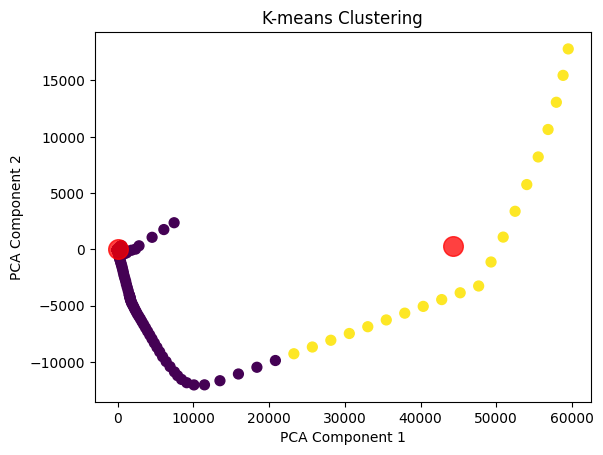

In [56]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Displayable clusters

num_clusters = 2

df = pd.read_csv("../data/5_nodes_1_week_fault_processed.csv")
df = df.iloc[10000:]
# Currently only looking at Node with Id 4126
df = df[df['node_id_4126'] == 1]
df = df.dropna()
X = df.drop(columns=['Unnamed: 0', 'is_fault'])
y = df['is_fault']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42).fit(X_pca)
# entry_clusters = kmeans.labels_
entry_clusters = kmeans.predict(X_pca)

clustering_score = 0
for index, cluster in enumerate(entry_clusters):
    clustering_score += 1 if bool(y.iloc[index]) != bool(cluster) else 0

print("Percentage of correctly clustered fault entries: ")
print(str(max(clustering_score/len(y), 1 - clustering_score/len(y)) * 100) + "%")


# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=entry_clusters, s=50, cmap='viridis')

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering')
plt.show()


### Looking at all nodes

Optimally, there will be 6 clusters, where each cluster represents a node and state (faulty or stable).

In [28]:
import pandas as pd 
from sklearn.cluster import KMeans

df = pd.read_csv("../data/5_nodes_1_week_fault_processed.csv")
df = df.iloc[10000:]
df = df.dropna()
X = df.drop(columns=['Unnamed: 0', 'is_fault'])
y = df['is_fault']

# Finding the optimal number of clusters
cluster_dict = {}
for num_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=num_clusters, random_state=43).fit(X) 
    entry_clusters = kmeans.labels_ # same as kmeans.predict(X) in this case
    # entry_clusters = kmeans.predict(X)

{2: 95.70395026436677, 3: 95.70514734526789, 4: 95.70213754185936, 5: 95.70107727020407, 6: 95.69933295231958, 7: 95.6994013569425, 8: 95.69984598699149, 9: 95.69960657081127, 10: 95.70076944940092, 11: 95.72915736791325, 12: 95.72915736791325, 13: 95.72915736791325, 14: 95.72915736791325, 15: 95.74577969128309, 16: 95.74581389359456, 17: 95.72601075525886, 18: 87.8139216404523, 19: 87.81275876186264}


In [34]:
import pandas as pd 
from sklearn.cluster import KMeans

df = pd.read_csv("../data/5_nodes_1_week_fault_processed.csv")
df = df.iloc[10000:]
df = df.dropna()
X = df.drop(columns=['Unnamed: 0', 'is_fault'])
y = df['is_fault']

# Finding the optimal number of clusters
num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters, random_state=43).fit(X) 
entry_clusters = kmeans.labels_ # same as kmeans.predict(X) in this case
# entry_clusters = kmeans.predict(X)
clustering_score = 0
for index, cluster in enumerate(entry_clusters):
    clustering_score += 1 if bool(y.iloc[index]) != bool(cluster) else 0

print("Percentage of correctly clustered fault entries: ")
print(str(max(clustering_score/len(y), 1 - clustering_score/len(y)) * 100) + "%")


Percentage of correctly clustered fault entries: 
95.70395026436677%


Percentage of correctly clustered fault entries: 
95.70395026436677%


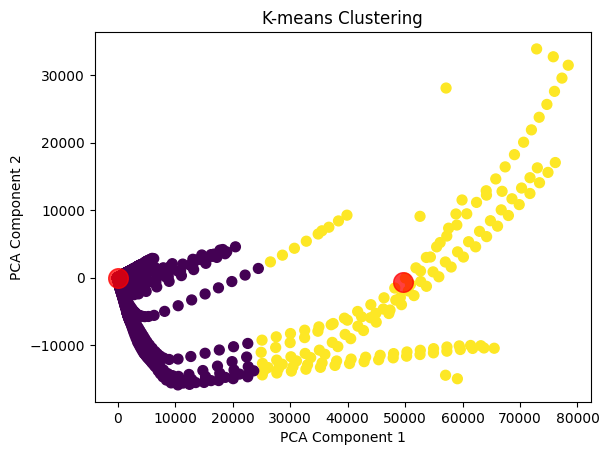

In [35]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Displayable clusters

num_clusters = 2

df = pd.read_csv("../data/5_nodes_1_week_fault_processed.csv")
df = df.iloc[10000:]
# Currently only looking at Node with Id 4126
df = df.dropna()
X = df.drop(columns=['Unnamed: 0', 'is_fault'])
y = df['is_fault']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42).fit(X_pca)
# entry_clusters = kmeans.labels_
entry_clusters = kmeans.predict(X_pca)

clustering_score = 0
for index, cluster in enumerate(entry_clusters):
    clustering_score += 1 if bool(y.iloc[index]) != bool(cluster) else 0

print("Percentage of correctly clustered fault entries: ")
print(str(max(clustering_score/len(y), 1 - clustering_score/len(y)) * 100) + "%")


# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=entry_clusters, s=50, cmap='viridis')

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering')
plt.show()


In [38]:
cluster_count = {}
for cluster in entry_clusters:
    if cluster_count.get(cluster) is None:
        cluster_count[cluster] = 1
    else:
        cluster_count[cluster] += 1
    
print(cluster_count)

{0: 2923630, 1: 149}


## Correlation Matrix of Features

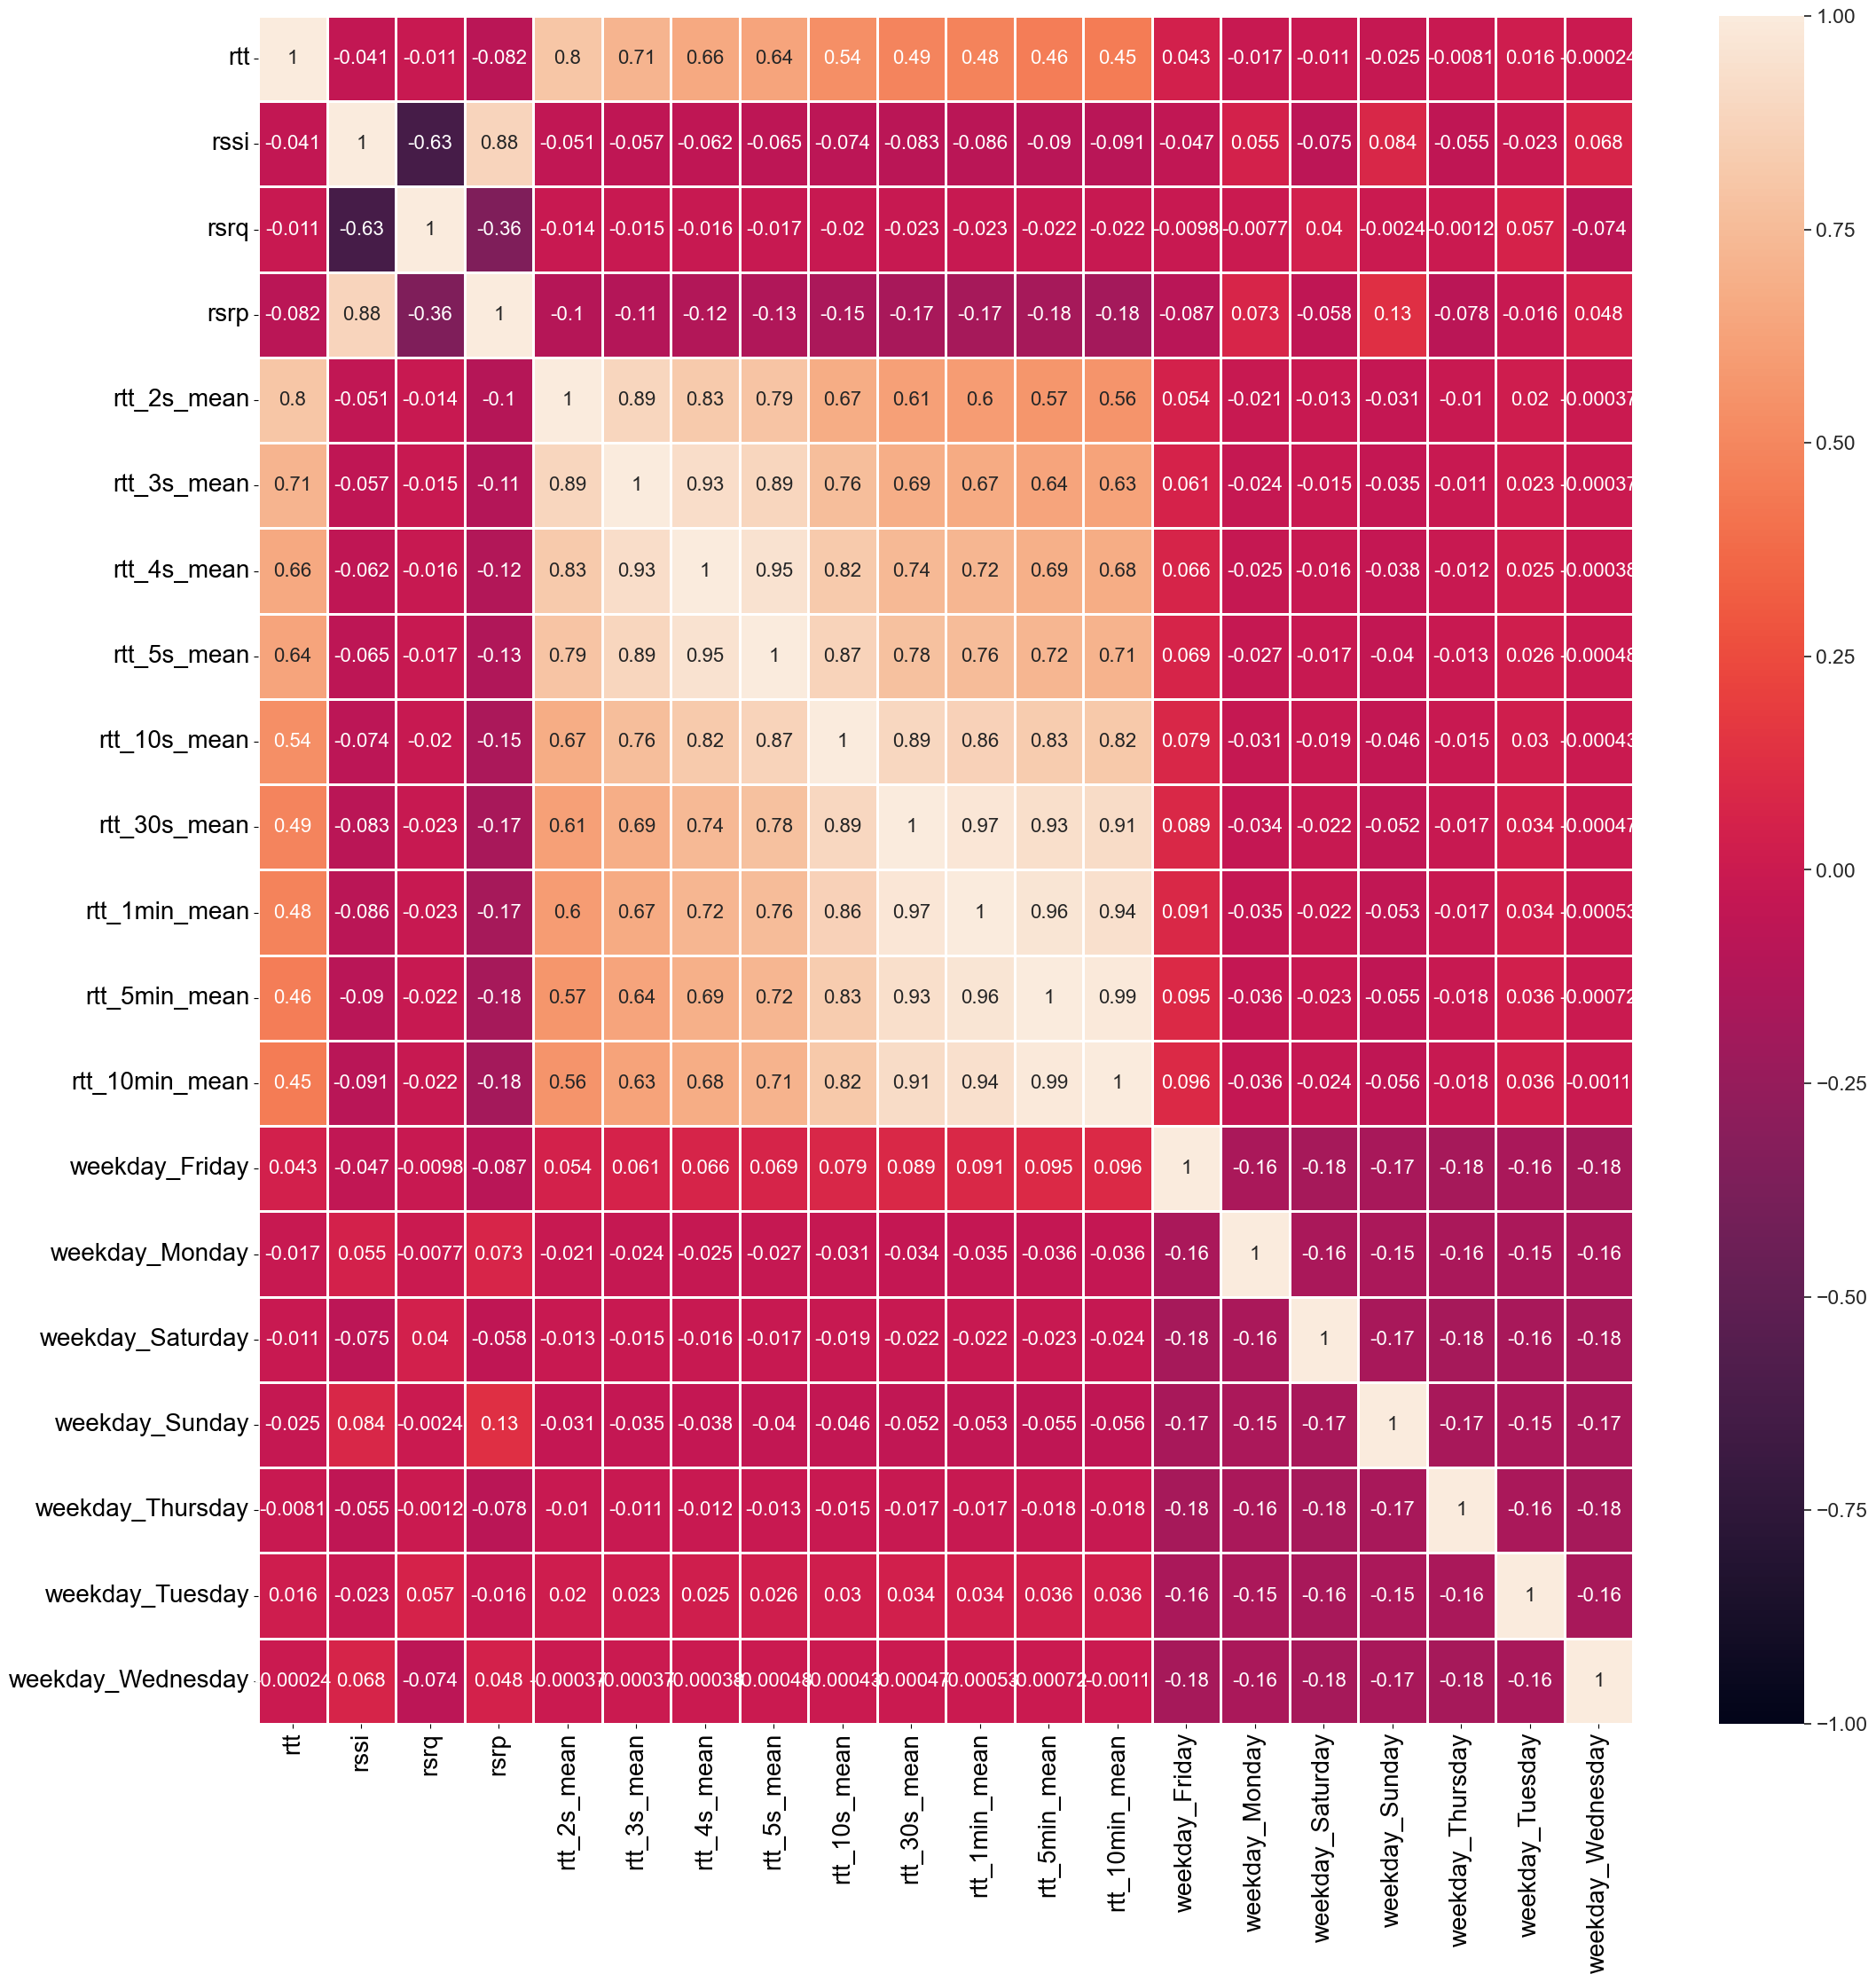

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/3_month_data/4120_3_months_aggregated_proc.csv")
df = df.drop(columns=['Unnamed: 0', 'node_id', 'ts', 'is_fault', 
                      'hour_0',
                      'hour_1',
                      'hour_2',
                      'hour_3',
                      'hour_4',
                      'hour_5',
                      'hour_6',
                      'hour_7',
                      'hour_8',
                      'hour_9',
                      'hour_10',
                      'hour_11',
                      'hour_12',
                      'hour_13',
                      'hour_14',
                      'hour_15',
                      'hour_16',
                      'hour_17',
                      'hour_18',
                      'hour_19',
                      'hour_20',
                      'hour_21',
                      'hour_22',
                      'hour_23'
                      ])
correlation =df.iloc[:].corr(method='pearson') # spearman, kendall, pearson(default)
     
# Set the matplotlib figure 
fig, ax = plt.subplots(figsize=(25,25))
sns.diverging_palette(220, 10, as_cmap=True)
sns.set_theme(font_scale=1.5)  # Adjust the font scale here
sns.heatmap(correlation,  ax=ax, annot=True,   vmin=-1, linewidths=2, annot_kws={"size": 16})
ax.tick_params(axis='both', which='major', labelsize=20)  # Set font size for both x and y ticks
ax.figure.savefig('pearson-corr.png')

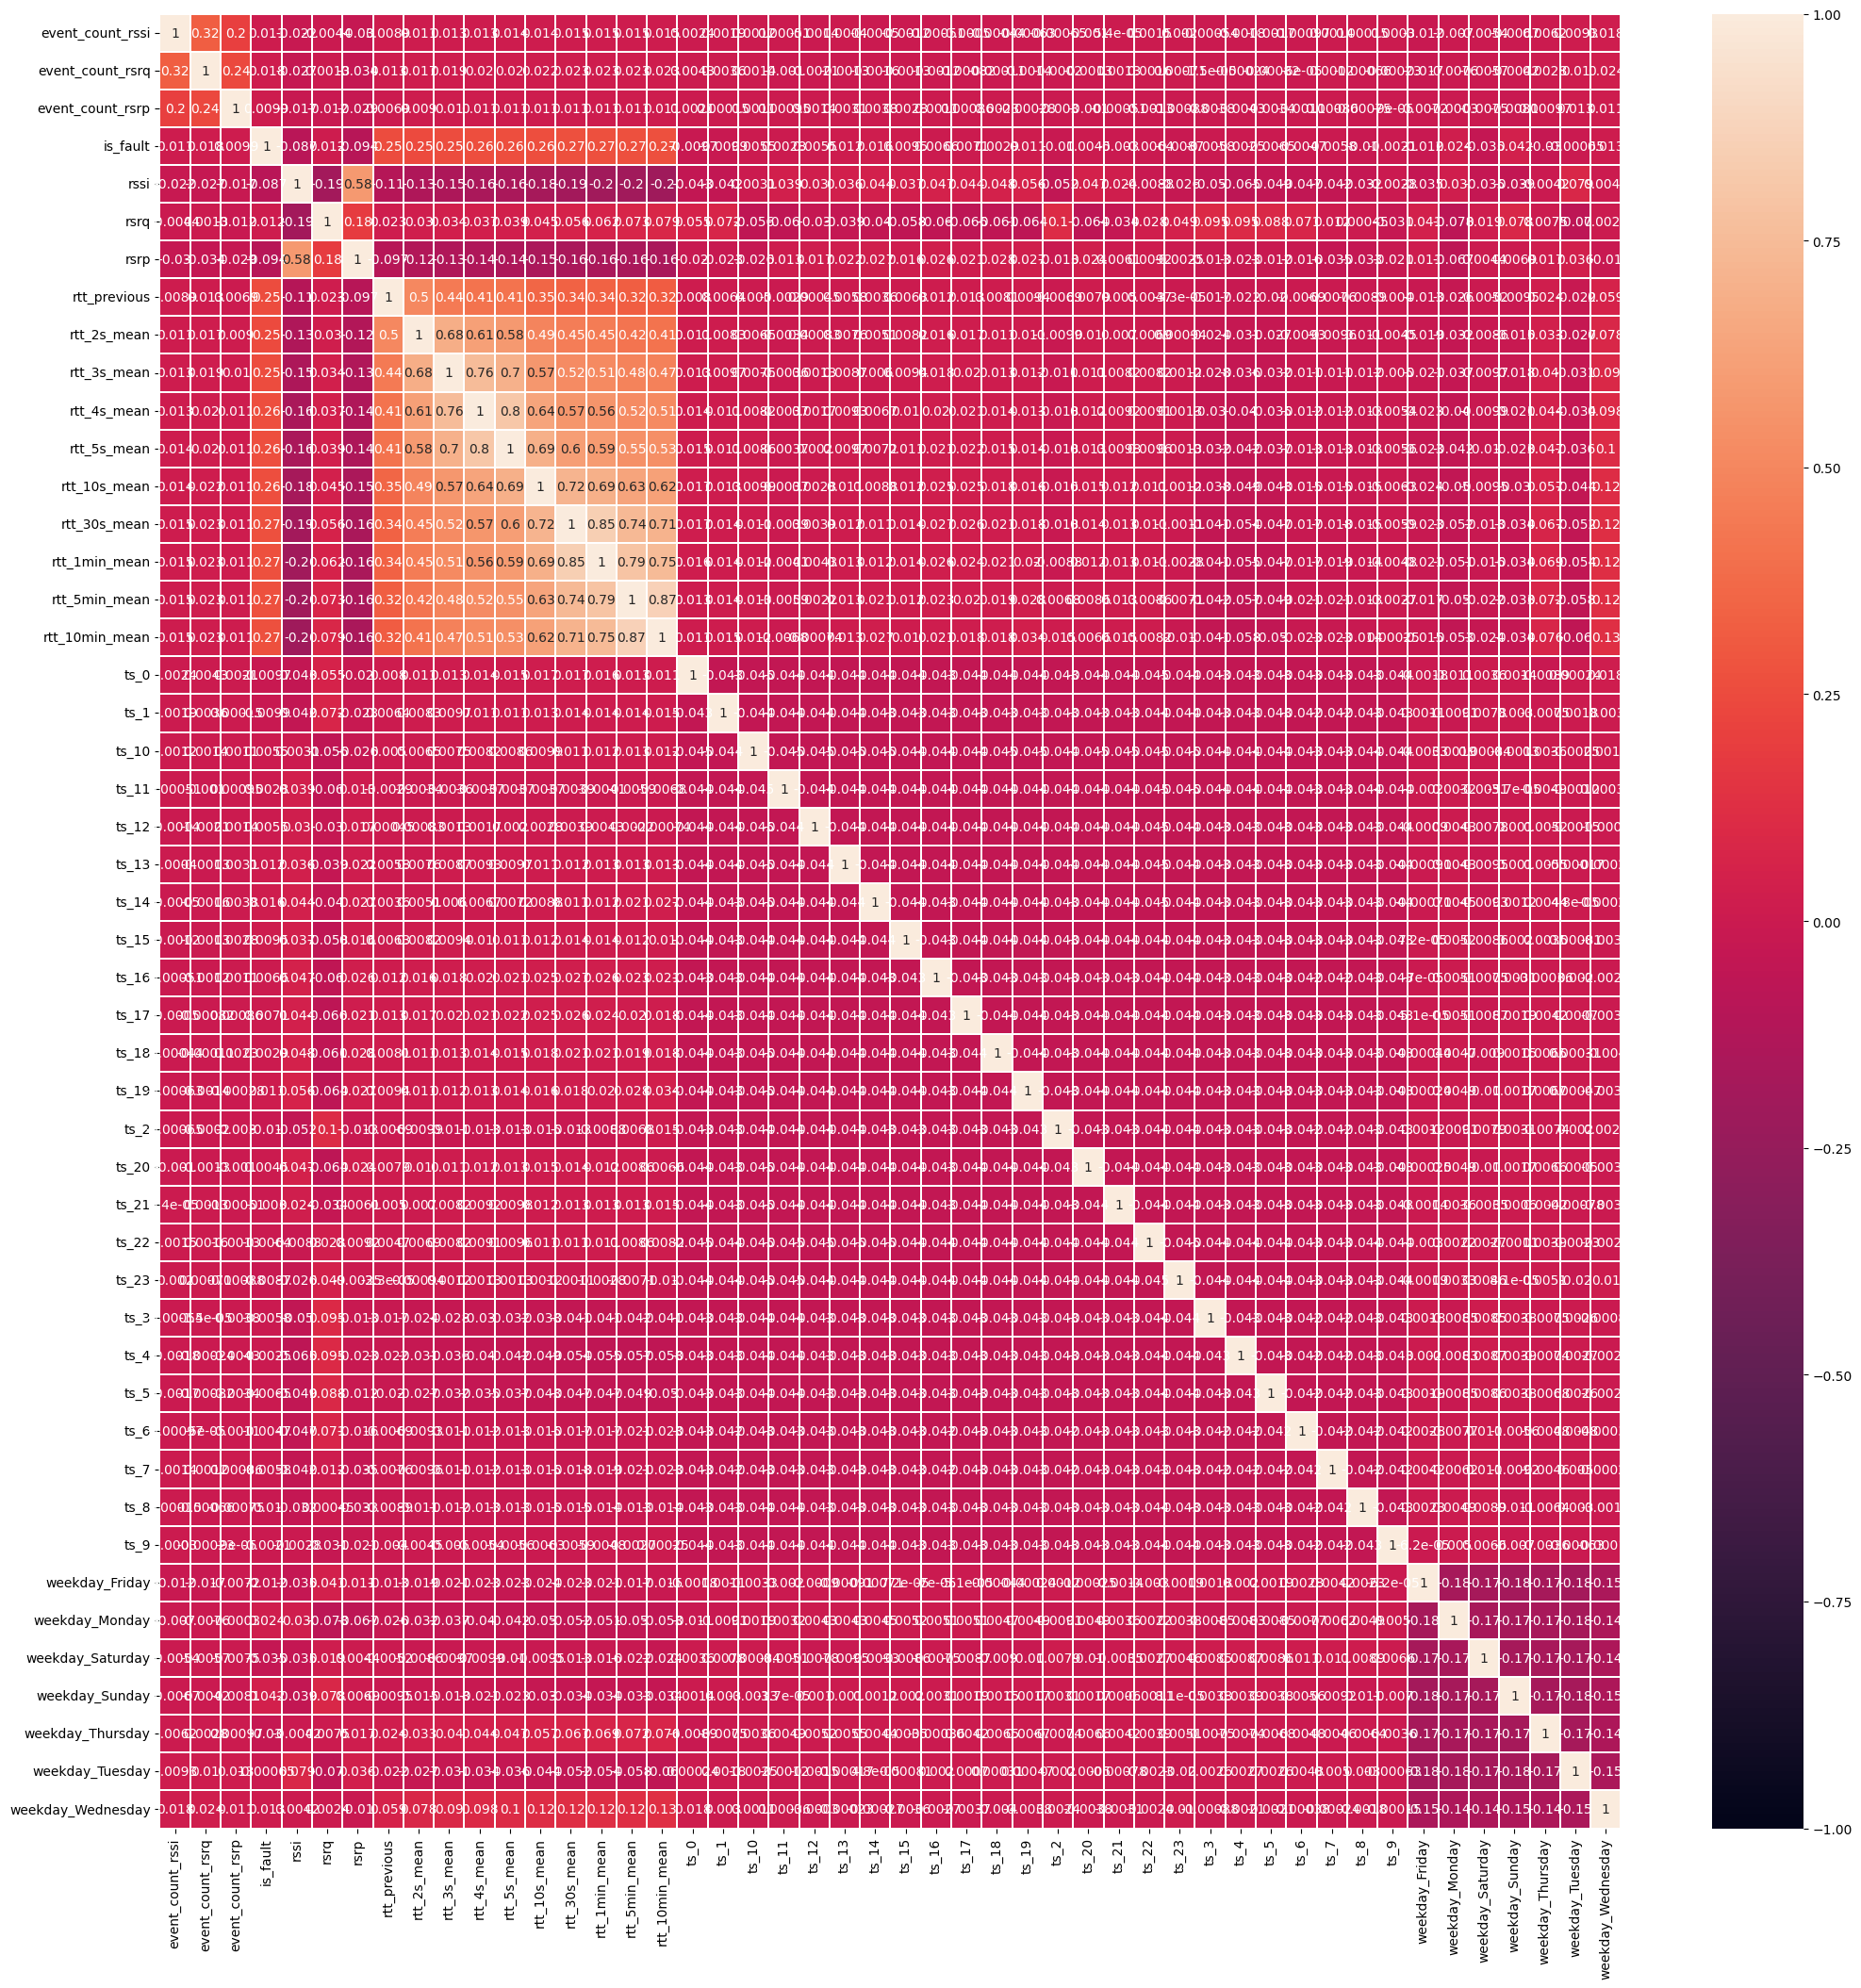

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/1_node_3_months_fault_processed.csv")
df = df.drop(columns=['Unnamed: 0', 'node_id_4125', 'population_LOW'])
correlation =df.iloc[:].corr(method='kendall') # spearman, kendall, pearson(default)
     
# Set the matplotlib figure 
fig, ax = plt.subplots(figsize=(25,25))
sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation,  ax=ax, annot=True,   vmin=-1, linewidths=0.2)
ax.figure.savefig('kendall-corr.png')

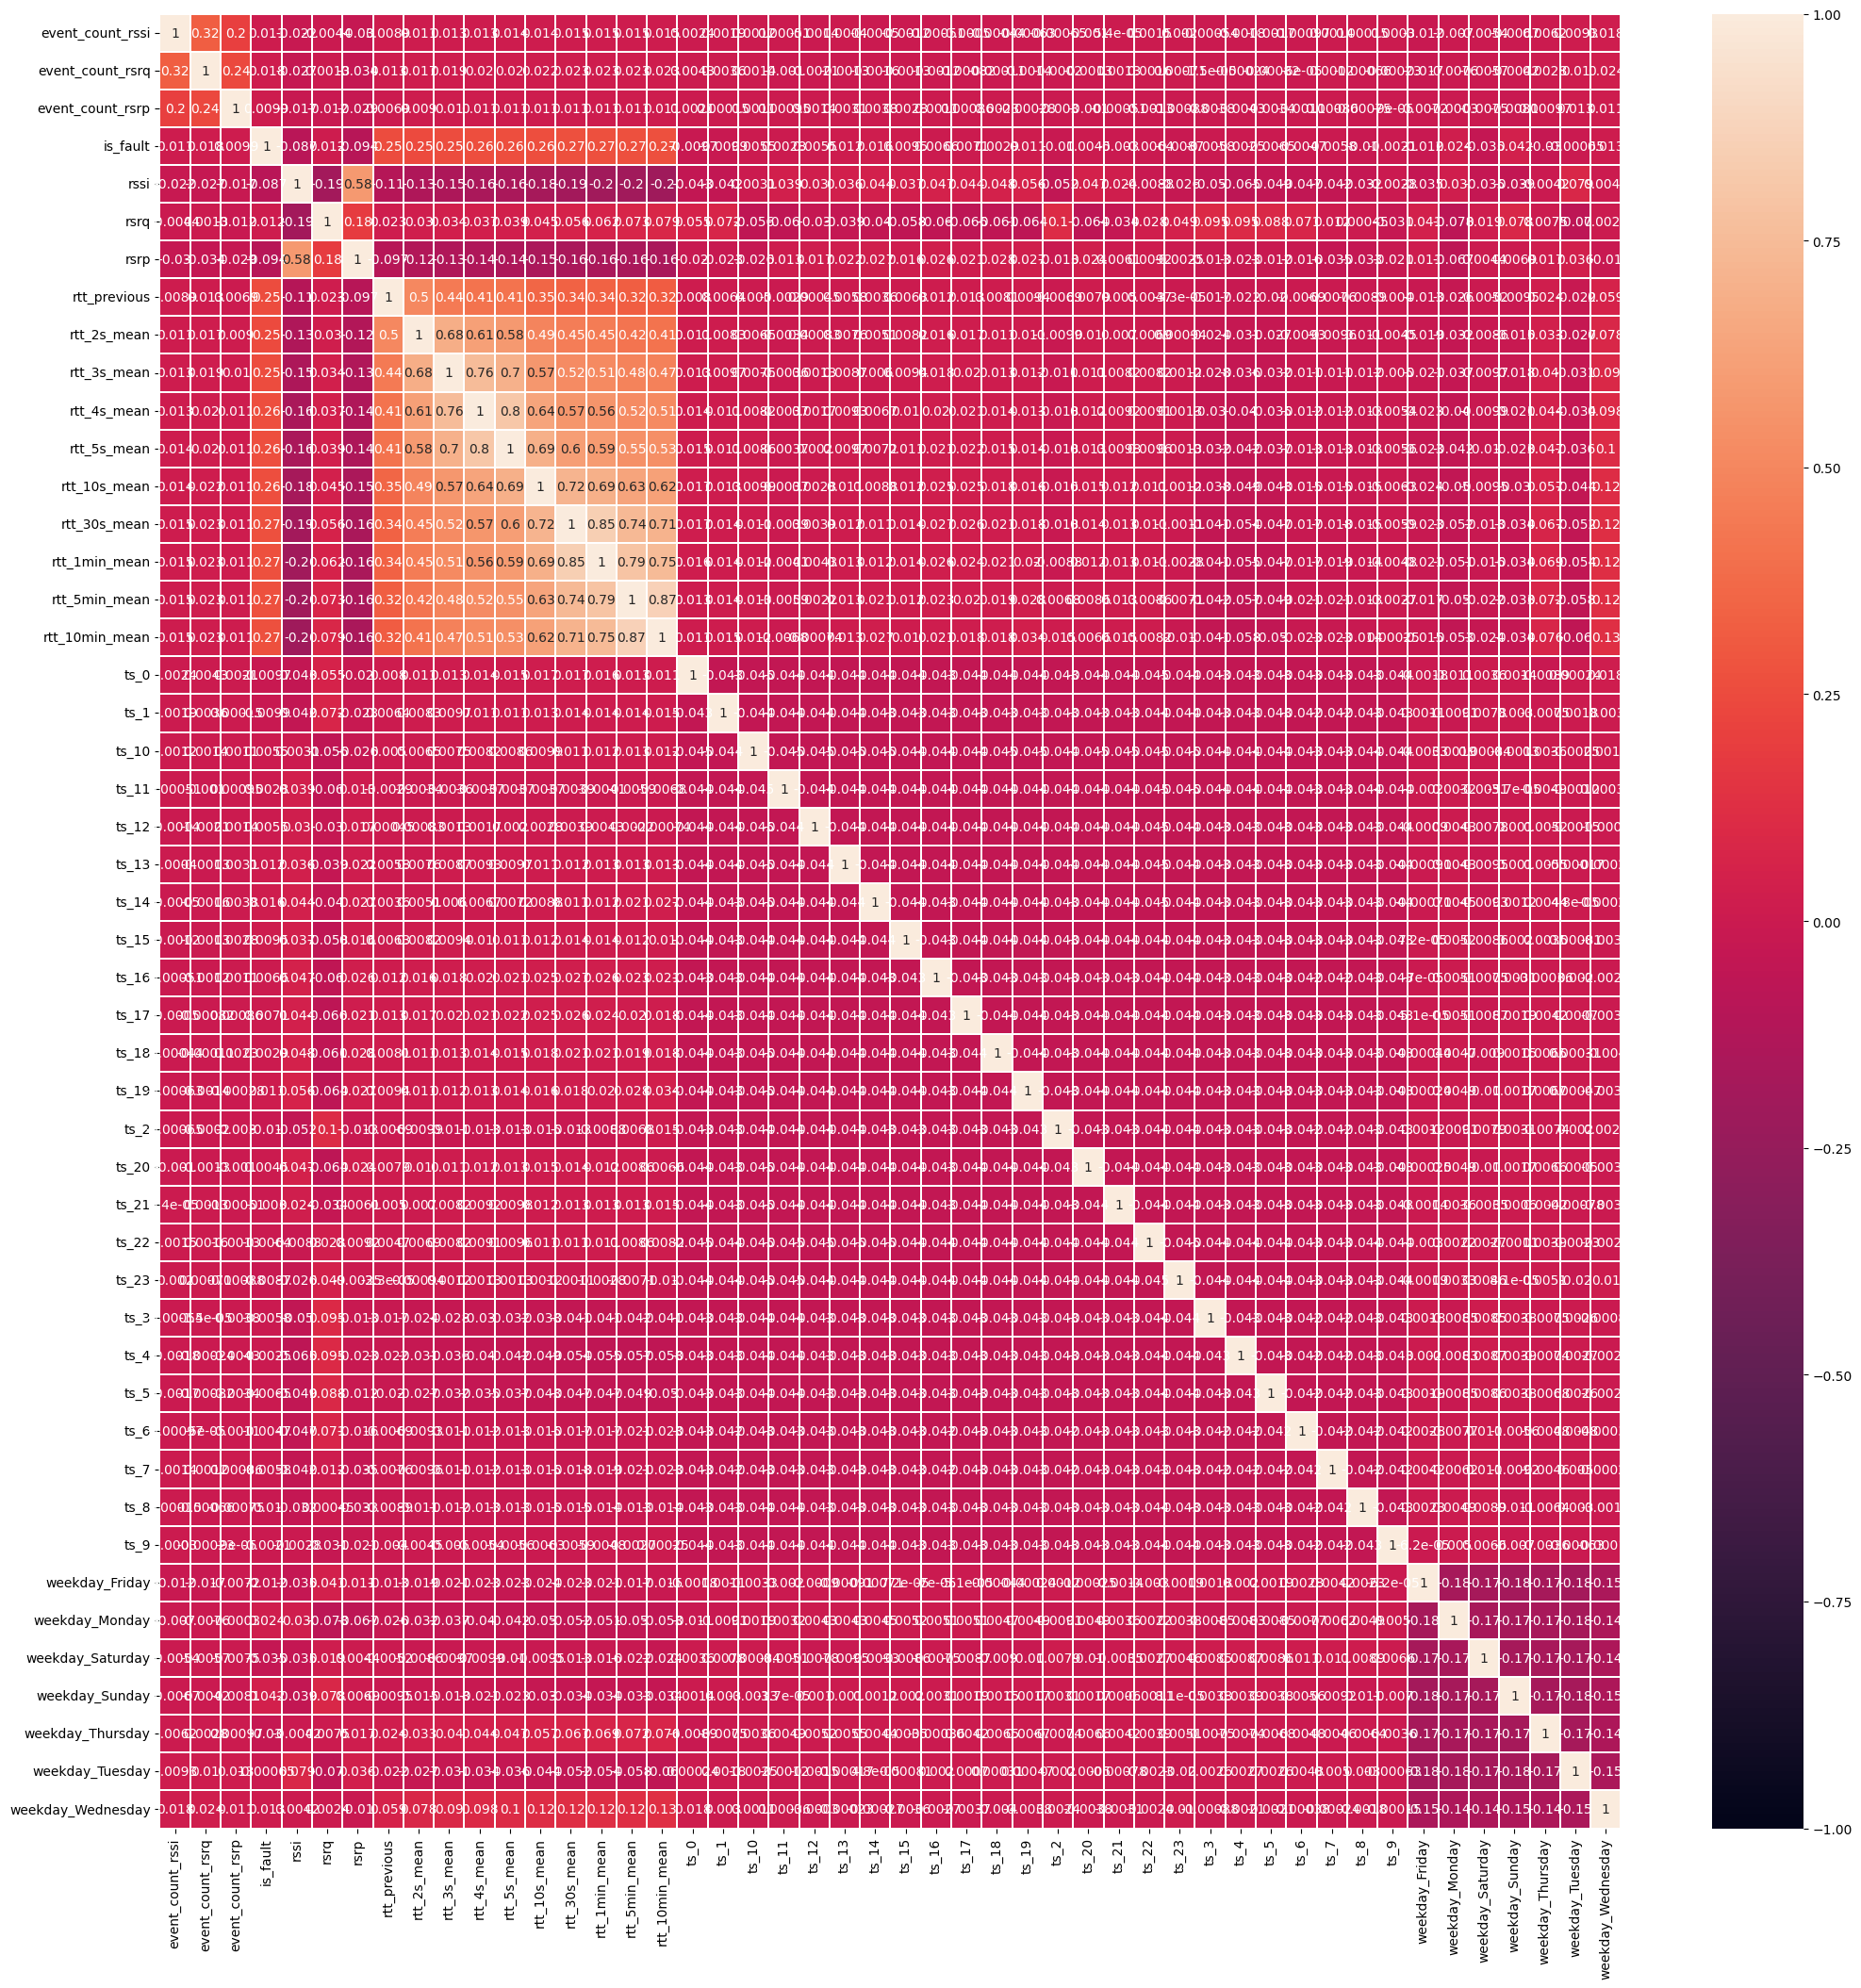

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/1_node_3_months_fault_processed.csv")
df = df.drop(columns=['Unnamed: 0', 'node_id_4125', 'population_LOW'])
correlation =df.iloc[:].corr(method='spearman') # spearman, kendall, pearson(default)
     
# Set the matplotlib figure 
fig, ax = plt.subplots(figsize=(25,25))
sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation,  ax=ax, annot=True,   vmin=-1, linewidths=0.2)
ax.figure.savefig('spearman-corr.png')